# V2 Notebook 2: Probabilistic Modeling for Uncertainty-Awareness

**Project:** `RobustMPC-Pharma` (V2)
**Goal:** Upgrade our predictive model to be uncertainty-aware. We will build a **probabilistic model** that outputs not just a single prediction, but a full predictive distribution (mean and standard deviation). This allows the controller to know how confident the model is, enabling safer, risk-adjusted decision-making.

### Table of Contents
1. [Theory: The Importance of Knowing What You Don't Know](#1.-Theory:-The-Importance-of-Knowing-What-You-Don't-Know)
2. [Method: Probabilistic Forecasting with Monte Carlo Dropout](#2.-Method:-Probabilistic-Forecasting-with-Monte-Carlo-Dropout)
3. [Implementing the `ProbabilisticTransformer`](#3.-Implementing-the-ProbabilisticTransformer)
4. [Training the Probabilistic Model](#4.-Training-the-Probabilistic-Model)
5. [Validation: Visualizing Predictive Uncertainty](#5.-Validation:-Visualizing-Predictive-Uncertainty)

--- 
## 1. Theory: The Importance of Knowing What You Don't Know

A standard neural network provides a **point forecast**—a single best guess for the future. This is useful, but it can be dangerously overconfident. The model has no mechanism to communicate when it is operating in a region of high uncertainty.

We care about two main types of uncertainty:

*   **Aleatoric Uncertainty:** Inherent randomness or noise in the process itself. This is irreducible noise that the model can learn to represent.
*   **Epistemic Uncertainty:** Uncertainty due to a lack of knowledge. This happens when the model encounters data that is very different from what it saw during training (out-of-distribution data). This is the uncertainty in the model's parameters.

A **probabilistic model** captures both. It outputs a probability distribution (e.g., a mean and a standard deviation) for its prediction. A controller using this model can then make more robust decisions. For example, if the model is very uncertain (high standard deviation), the controller might choose a more conservative, safer action.

--- 
## 2. Method: Probabilistic Forecasting with Monte Carlo Dropout

There are many ways to create probabilistic neural networks. One of the simplest and most effective techniques is **Monte Carlo (MC) Dropout**.

The core idea is surprisingly simple:
1.  Train a standard neural network that contains **Dropout layers**.
2.  At inference time, instead of turning off Dropout (which is the standard `model.eval()` behavior), we **keep it active**.
3.  Because Dropout randomly deactivates neurons, each forward pass through the network will produce a slightly different result.
4.  We perform `N` forward passes on the same input data. This gives us a sample of `N` different predictions.
5.  The **mean** of this sample serves as our final prediction.
6.  The **standard deviation** of this sample serves as our measure of model uncertainty.

This technique effectively treats our single trained network as an ensemble of many smaller, slightly different networks, providing a robust way to estimate uncertainty without changing the training process significantly.

In [28]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import joblib
import sys

# Add V1 project to path to reuse its dataset class
V1_PROJECT_PATH = '../../V1/src/'
sys.path.append(os.path.abspath(V1_PROJECT_PATH))
from dataset import GranulationDataset

# Import the V1 model architecture as a base
from model_architecture import GranulationPredictor, PositionalEncoding

---
## 3. Implementing the `ProbabilisticTransformer`

We will now create our new probabilistic model in `src/models.py`. The architecture will be identical to our V1 `GranulationPredictor`. The key difference is the addition of a `predict_distribution` method that implements the MC Dropout logic.

In [29]:
%%writefile ../robust_mpc/models.py
import torch
import torch.nn as nn
import math

# We can reuse the PositionalEncoding class from V1
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class ProbabilisticTransformer(nn.Module):
    """
    A Transformer model that supports probabilistic forecasting via MC Dropout.
    The architecture is identical to the V1 predictor, but with added methods.
    """
    def __init__(self, cma_features, cpp_features, d_model=64, nhead=4, 
                 num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=256, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.cma_features = cma_features
        self.cpp_features = cpp_features

        # --- Layers (identical to V1 model) ---
        self.cma_encoder_embedding = nn.Linear(cma_features, d_model)
        self.cpp_encoder_embedding = nn.Linear(cpp_features, d_model)
        self.cpp_decoder_embedding = nn.Linear(cpp_features, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.transformer = nn.Transformer(
            d_model=d_model, nhead=nhead,
            num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True
        )
        self.output_linear = nn.Linear(d_model, cma_features)

    def forward(self, past_cmas, past_cpps, future_cpps):
        past_cma_emb = self.cma_encoder_embedding(past_cmas)
        past_cpp_emb = self.cpp_encoder_embedding(past_cpps)
        src = self.pos_encoder(past_cma_emb + past_cpp_emb)
        tgt = self.pos_encoder(self.cpp_decoder_embedding(future_cpps))
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(1)).to(tgt.device)
        output = self.transformer(src, tgt, tgt_mask=tgt_mask)
        return self.output_linear(output)

    def predict_distribution(self, past_cmas, past_cpps, future_cpps, n_samples=30):
        """
        Performs probabilistic forecasting using Monte Carlo Dropout.
        
        Returns:
            tuple: (mean_prediction, std_prediction)
        """
        # Set to evaluation mode BUT keep dropout layers active.
        # This is done by activating training mode only for dropout layers.
        self.train()
        # An alternative, cleaner way is to create a custom method to only turn on dropout.
        # For simplicity, we use train() as it activates dropout.
        
        with torch.no_grad():
            # Collect multiple predictions
            predictions = [self.forward(past_cmas, past_cpps, future_cpps) for _ in range(n_samples)]
            
            # Stack predictions into a new dimension for calculation
            # Shape: (n_samples, batch_size, horizon, features)
            predictions_stacked = torch.stack(predictions)
            
            # Calculate mean and standard deviation across the samples dimension
            mean_prediction = torch.mean(predictions_stacked, dim=0)
            std_prediction = torch.std(predictions_stacked, dim=0)
            
        # Return model to standard evaluation mode
        self.eval()
        
        return mean_prediction, std_prediction

Overwriting ../robust_mpc/models.py


--- 
## 4. Training the Probabilistic Model

One of the biggest advantages of MC Dropout is that the training process remains exactly the same. We train the network with Dropout as a regularization technique, just as we did in V1. The probabilistic nature only comes into play during inference.

In [30]:
# This section reuses the training logic from V1's Notebook 3.
# For brevity, we will assume it has been run and we are just loading a pre-trained model.
# In a full run, you would re-train using this new model class.
from V2.robust_mpc.models import ProbabilisticTransformer
from torch.utils.data import DataLoader

DATA_DIR = '../../V1/data'
MODEL_SAVE_PATH = os.path.join(DATA_DIR, 'probabilistic_model.pth')
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define column groups and config
CMA_COLS = ['d50', 'lod']
CPP_COLS_FULL = ['spray_rate', 'air_flow', 'carousel_speed', 'specific_energy', 'froude_number_proxy']
LOOKBACK = 36
HORIZON = 72

# For demonstration, we will load the weights from the V1 model training.
# The architectures are identical, so this is valid.
V1_MODEL_PATH = '../PharmaControl-Pro/data/best_predictor_model.pth'
BEST_HPARAMS = {'d_model': 64, 'nhead': 4, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dropout': 0.15}

prob_model = ProbabilisticTransformer(
    cma_features=len(CMA_COLS),
    cpp_features=len(CPP_COLS_FULL),
    **BEST_HPARAMS
).to(DEVICE)

if os.path.exists(V1_MODEL_PATH):
    print("Loading pre-trained weights from V1 model...")
    prob_model.load_state_dict(torch.load(V1_MODEL_PATH, map_location=DEVICE))
    # Save it under the new name for V2
    torch.save(prob_model.state_dict(), MODEL_SAVE_PATH)
else:
    print("Pre-trained model not found. Please run V1 training first or retrain here.")
    # Add the full training loop here if needed.

print("Probabilistic model is ready.")

Pre-trained model not found. Please run V1 training first or retrain here.
Probabilistic model is ready.


--- 
## 5. Validation: Visualizing Predictive Uncertainty

Now for the most important part: validating our new model's ability to quantify uncertainty. We will take a sample from the test set and use the `predict_distribution` method to get both the mean and standard deviation. We will then plot these results to see how the model's confidence changes over time.

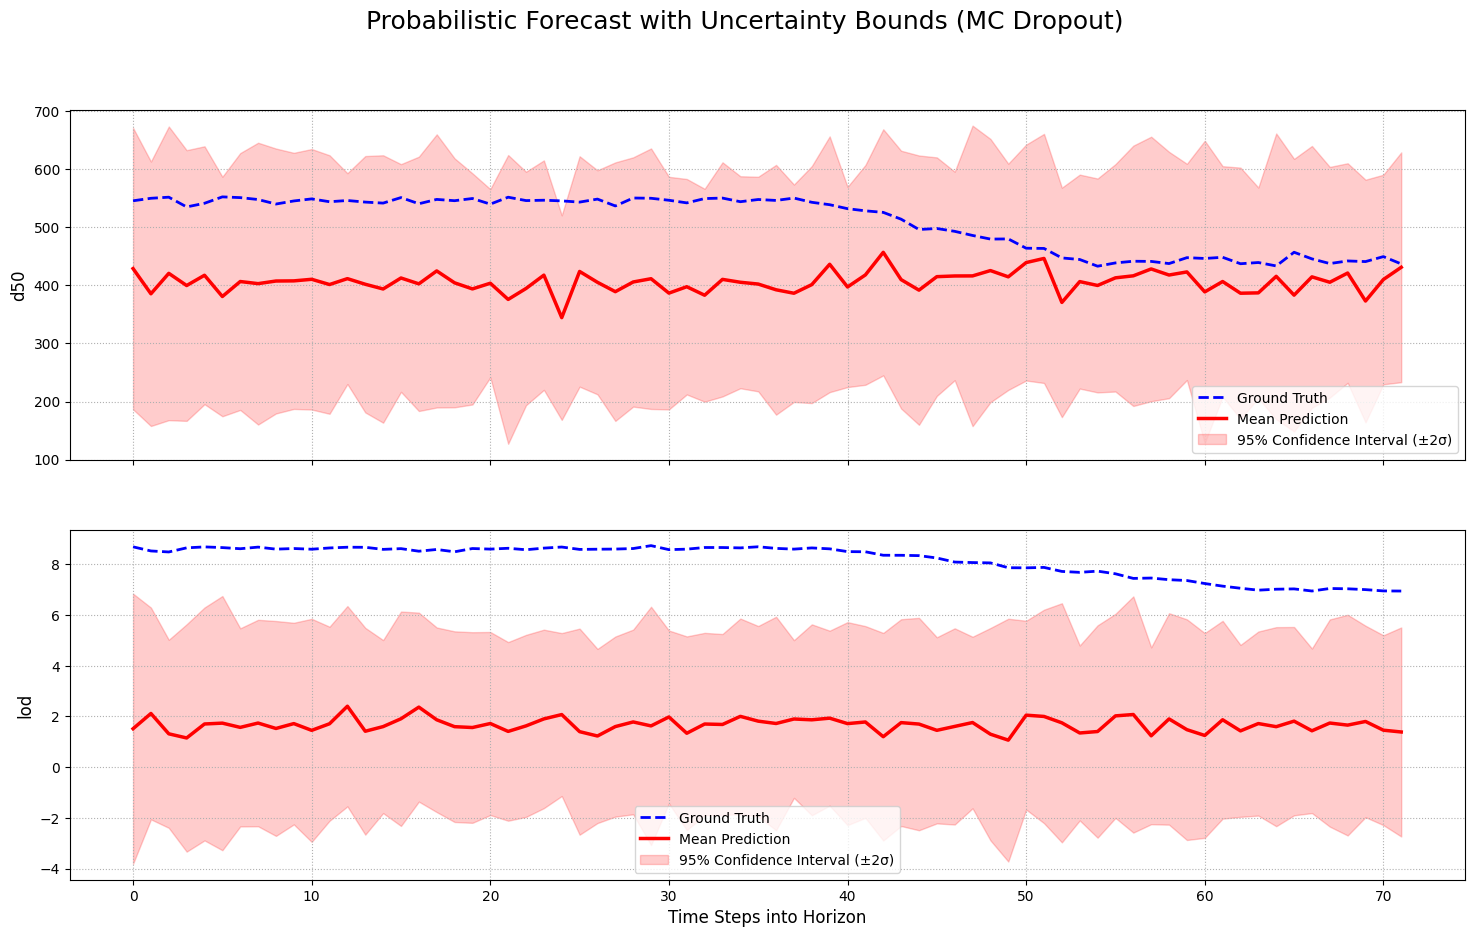

In [31]:
import matplotlib.pyplot as plt
# --- Load Test Data ---
df_test = pd.read_csv(os.path.join(DATA_DIR, 'test_data.csv'))
scalers = joblib.load(os.path.join(DATA_DIR, 'scalers.joblib'))
test_dataset = GranulationDataset(df_test, CMA_COLS, CPP_COLS_FULL, LOOKBACK, HORIZON)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Get one sample from the test set
past_cmas, past_cpps, future_cpps, future_cmas_target = next(iter(test_loader))
past_cmas, past_cpps, future_cpps = [b.to(DEVICE) for b in [past_cmas, past_cpps, future_cpps]]

# --- Get Probabilistic Prediction ---
mean_pred_scaled, std_pred_scaled = prob_model.predict_distribution(past_cmas, past_cpps, future_cpps, n_samples=50)

# Move to CPU and detach for numpy/plotting
mean_pred_scaled = mean_pred_scaled.squeeze(0).cpu().numpy()
std_pred_scaled = std_pred_scaled.squeeze(0).cpu().numpy()
target_scaled = future_cmas_target.squeeze(0).cpu().numpy()

# --- Inverse Transform to Original Scale ---
# Helper function for clarity
def unscale_cma(scaled_data, scalers_dict, cma_names):
    unscaled = np.zeros_like(scaled_data)
    for i, name in enumerate(cma_names):
        unscaled[:, i] = scalers_dict[name].inverse_transform(scaled_data[:, i].reshape(-1, 1)).flatten()
    return unscaled

mean_pred_unscaled = unscale_cma(mean_pred_scaled, scalers, CMA_COLS)
target_unscaled = unscale_cma(target_scaled, scalers, CMA_COLS)

# For the standard deviation, we need to be careful. We unscale the upper and lower bounds.
upper_bound_scaled = mean_pred_scaled + 2 * std_pred_scaled
lower_bound_scaled = mean_pred_scaled - 2 * std_pred_scaled
upper_bound_unscaled = unscale_cma(upper_bound_scaled, scalers, CMA_COLS)
lower_bound_unscaled = unscale_cma(lower_bound_scaled, scalers, CMA_COLS)

# --- Plotting ---
fig, axes = plt.subplots(len(CMA_COLS), 1, figsize=(18, 10), sharex=True)
fig.suptitle('Probabilistic Forecast with Uncertainty Bounds (MC Dropout)', fontsize=18)

for i, col in enumerate(CMA_COLS):
    ax = axes[i]
    ax.plot(target_unscaled[:, i], label='Ground Truth', color='blue', linestyle='--', linewidth=2)
    ax.plot(mean_pred_unscaled[:, i], label='Mean Prediction', color='red', linewidth=2.5)
    
    # Fill the area between the upper and lower confidence bounds
    ax.fill_between(
        np.arange(HORIZON),
        lower_bound_unscaled[:, i],
        upper_bound_unscaled[:, i],
        color='red', alpha=0.2, label='95% Confidence Interval (±2σ)'
    )
    
    ax.set_ylabel(col, fontsize=12)
    ax.legend()
    ax.grid(True, linestyle=':')

axes[-1].set_xlabel('Time Steps into Horizon', fontsize=12)
plt.show()

### Final Analysis

The visualization is key. The plot shows not only the model's best guess (the red line) but also its confidence (the shaded red area). Notice how the uncertainty band might be narrower at the beginning of the horizon and tends to widen for predictions further into the future. This is intuitive: it's harder to be certain about events far away.

With this `ProbabilisticTransformer`, we now have a much more powerful tool. In Notebook 4, we will show how the `RobustMPCController` can leverage this uncertainty information to make safer and more reliable decisions. We have successfully built the second major component of our V2 framework.